Looking at how the libration motion of the moon will affect signals bouncing off of it and how RA and Dec will be affected for a moon-based telescope

This is the figure I used for the landing sites: ![landing](https://upload.wikimedia.org/wikipedia/commons/3/34/Moon_landing_sites.svg)

In [1]:
import matplotlib.pyplot as plt
import horizons
import numpy as np
from scipy.integrate import odeint
import astropy.units as u
import astropy.constants as c
from astroquery.jplhorizons import Horizons
%matplotlib notebook

In [2]:
#Looking at the center of the Moon from Hat Creek 
mhc = Horizons(id = '301', location = 'Hat Creek Observatory (Allen Array)@399', epochs = 
                   {'start':'2023-06-15', 'stop':'2023-07-15', 'step':'1d'})
moon_hc = mhc.ephemerides()

In [3]:
#Looking at the center of the Earth from the center of the Moon
mg = Horizons(id = '399', location = '500@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'1m'})
moon_geo = mg.ephemerides()

In [4]:
#Looking at the center of the Earth from the Center of the Moon for a longer step rate
mg1 = Horizons(id = '399', location = '500@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'5m'})
moon_geo1 = mg1.ephemerides()

In [5]:
#Looking at the center of the Earth from the Luna 16 landing site
ml = Horizons(id = '399', location = 'Luna-16 (landing site)@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'1m'})
moon_luna = ml.ephemerides()

In [6]:
#Looking at the center of the Earth from the Surveyor 6 landing site
ms = Horizons(id = '399', location = 'Surveyor-6 (landing site)@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'10m'})
moon_surveyor = ms.ephemerides()

In [7]:
#Looking at the center of the Moon from the center of the Earth 
mgeg = Horizons(id = '301', location = '500', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'30m'})
earth_geo = mgeg.ephemerides()

In [8]:
#Looking at the center of the Earth from the Center of the Moon for an even longer step rate
mg2 = Horizons(id = '399', location = '500@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-07-16 00:00', 'step':'10m'})
moon_geo2 = mg2.ephemerides()

The first thing we're going to do here is plot the doppler drift due to both the overall motion of the moon and the libration motion alone

In [10]:
r_g = [] #radial distance between the center of the Earth and the center of the Moon
rdot_g = [] #radial velocity between the center of the Earth and the center of the Moon
time_g = [] #time from the ephemeris
for i in range(len(moon_geo)):
    r_g.append(moon_geo.columns[40][i])
    rdot_g.append(moon_geo.columns[41][i])
    time_g.append(moon_geo.columns[1][i])
    
r_l = [] #radial distance between the center of the Earth and the Luna 16 landing site
rdot_l = [] #radial velocity between the center of the Earth and the Luna 16 landing site
time_l = [] #time from the ephemeris
for i in range(len(moon_luna)):
    r_l.append( moon_luna.columns[40][i])
    rdot_l.append( moon_luna.columns[41][i])
    time_l.append(moon_luna.columns[1][i])

In [11]:
#subtract the Luna 16 info from the Moon center info to get the libration
dr = []
drdot = []
t = []
for i in range(len(moon_geo)):
    dr.append(np.abs(r_g[i] - r_l[i]))
    drdot.append(np.abs(rdot_g[i] - rdot_l[i]))
    t.append(time_g[i])

In [12]:
#Equation to calculate the doppler shift
def doppler(freq, velocity):
    w = c.c/freq
    return (velocity*w/c.c)

In [13]:
doppler_d = [] #m
doppler_g = [] #m
f = 1420405752 #neutral hydrogen line
#for reference, w = 2.8470319m for this sf
for i in range(len(r_g)):
    doppler_d.append(doppler(f, dr[i] * 10**3))
    doppler_g.append(doppler(f, r_g[i] * 10 ** 3))

<IPython.core.display.Javascript object>


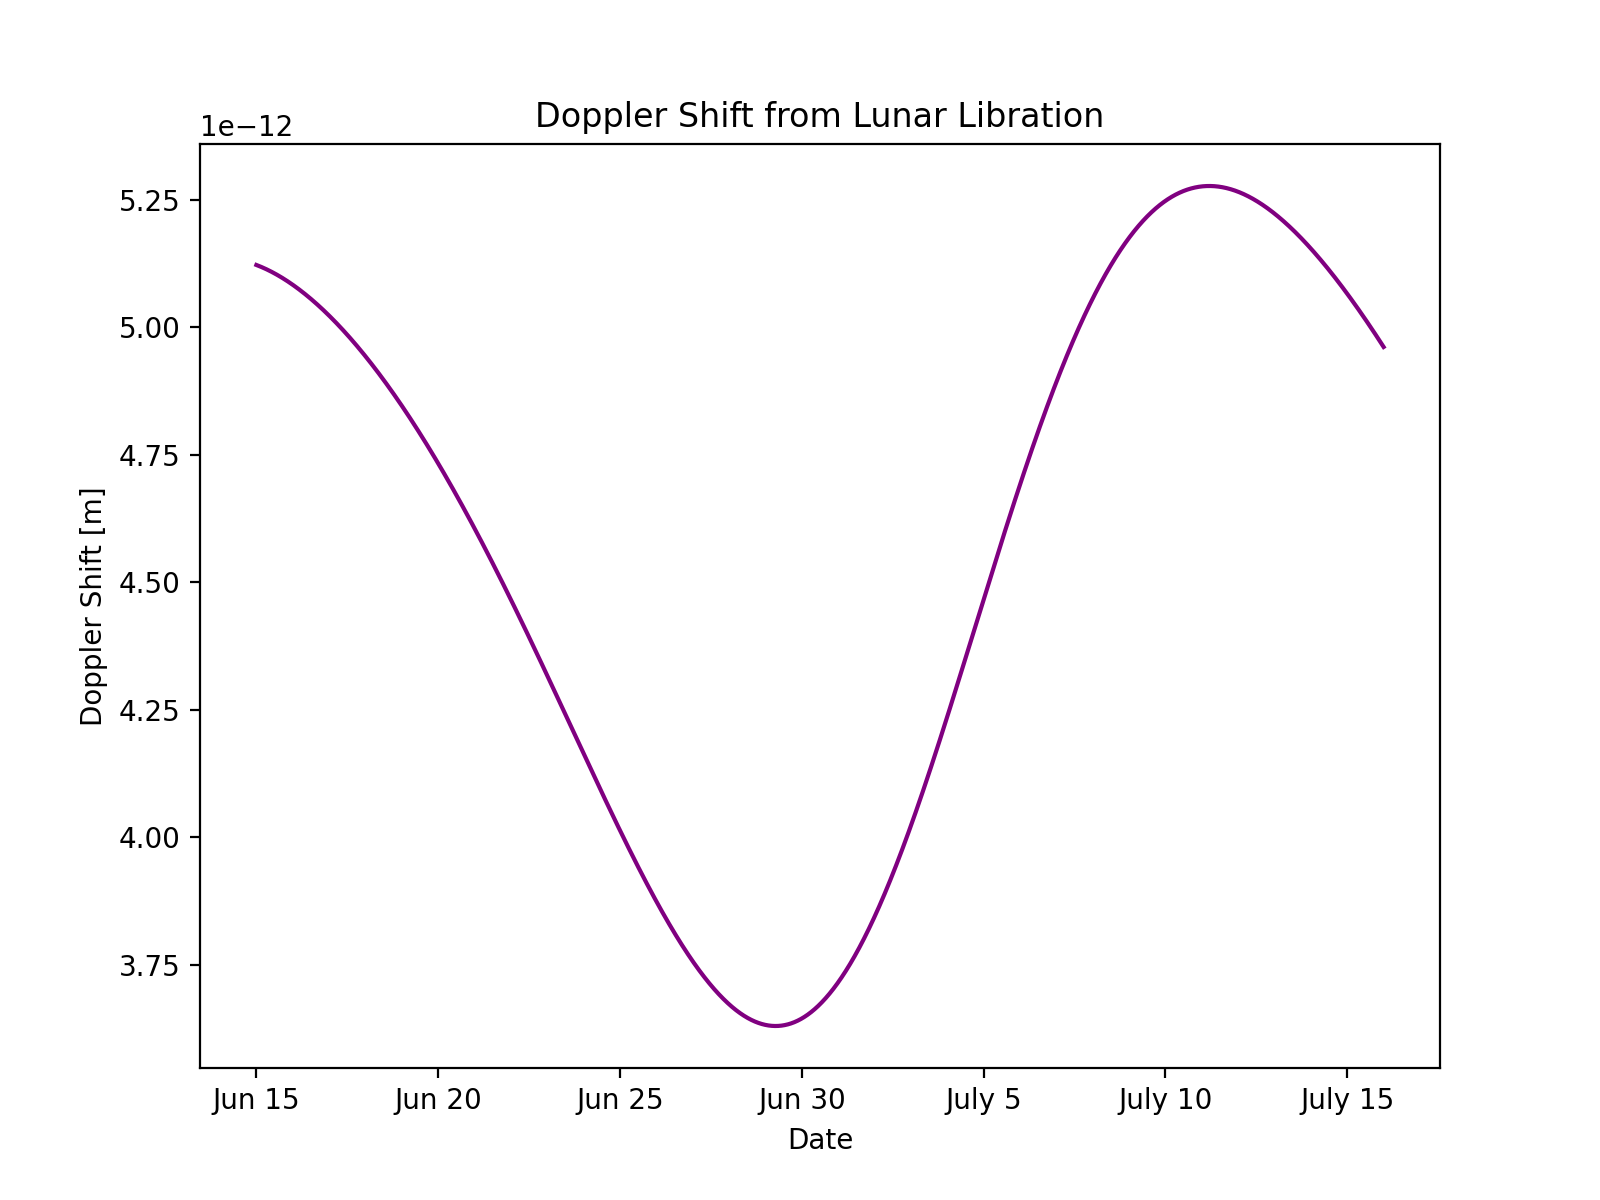

In [14]:
plt.figure(figsize = (8, 6))
plt.plot(t, doppler_d, 'purple')
plt.xticks(ticks = [t[0], t[7200], t[14400], t[21600], t[28800], t[36000], t[43200]], 
           labels = ['Jun 15', 'Jun 20', 'Jun 25', 'Jun 30', 'July 5', 'July 10', 'July 15'])
plt.title('Doppler Shift from Lunar Libration')
plt.xlabel('Date')
plt.ylabel('Doppler Shift [m]')
plt.show()

<IPython.core.display.Javascript object>


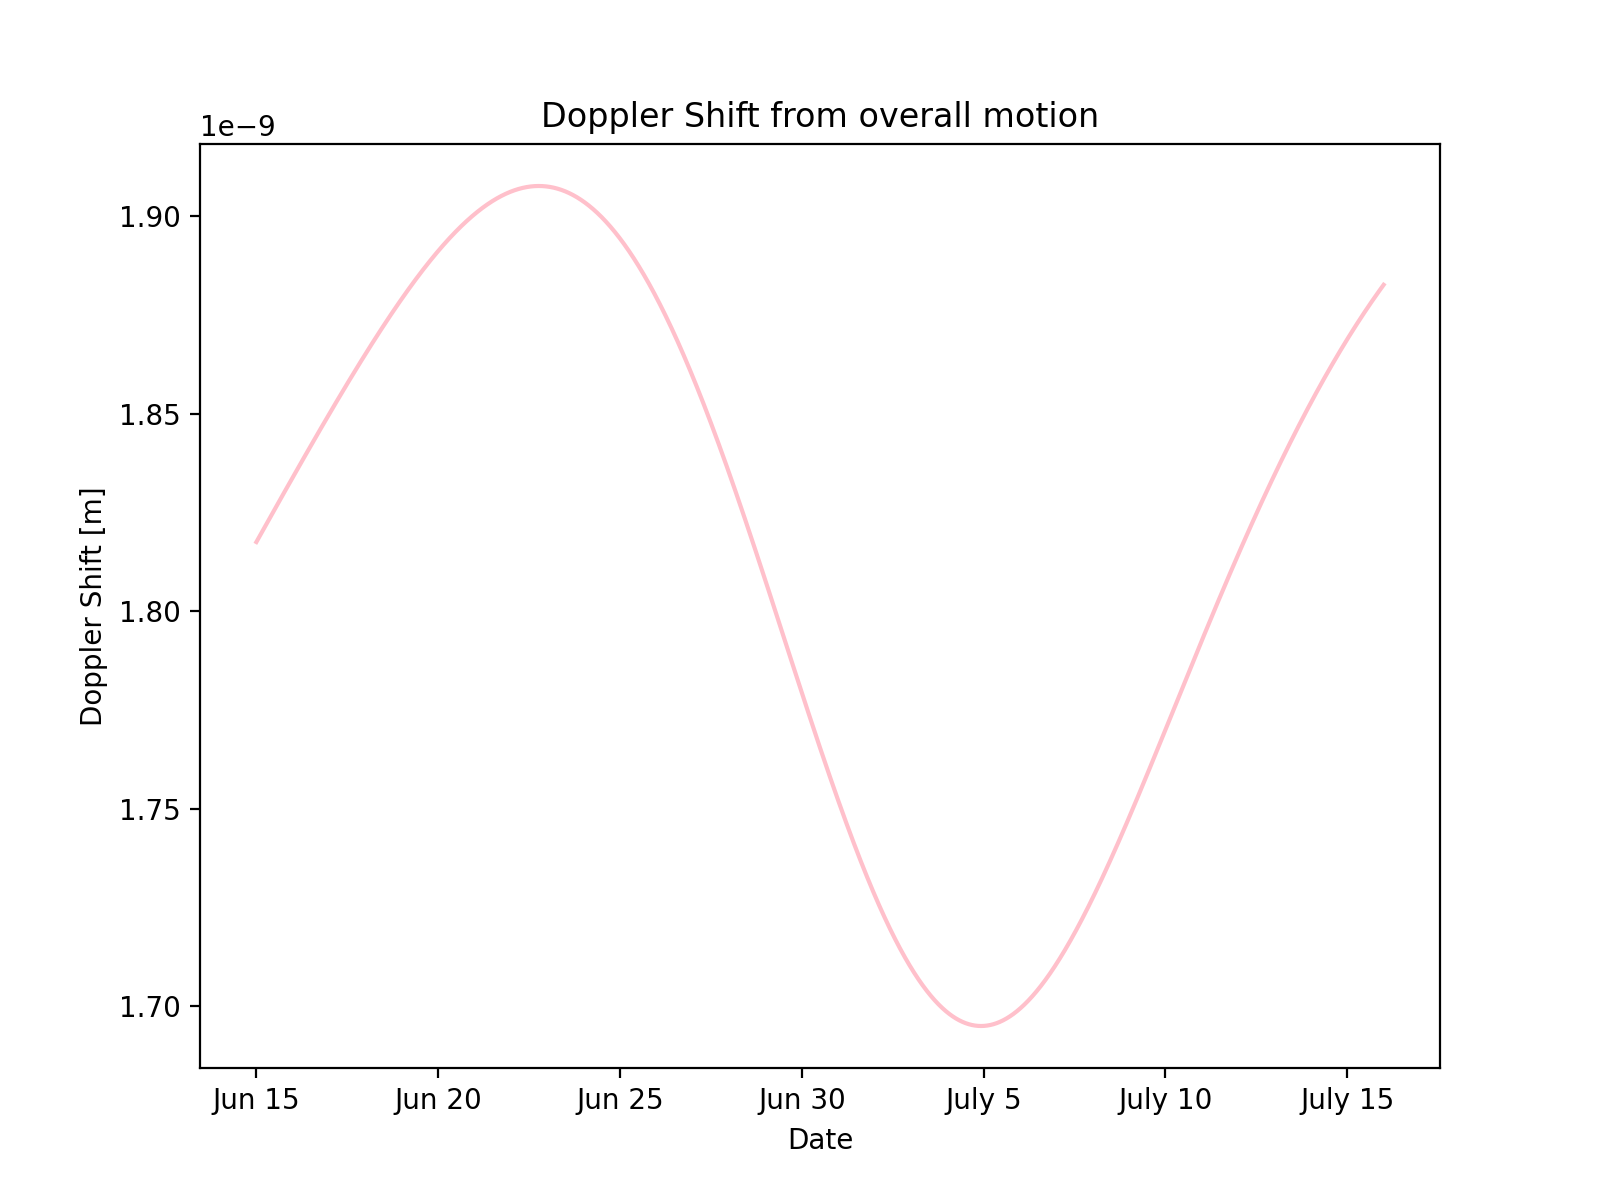

In [15]:
plt.figure(figsize = (8, 6))
plt.plot(time_g, doppler_g, 'pink')
#plt.plot(time_g1, doppler_d1, 'k')
plt.xticks(ticks = [t[0], t[7200], t[14400], t[21600], t[28800], t[36000], t[43200]], 
           labels = ['Jun 15', 'Jun 20', 'Jun 25', 'Jun 30', 'July 5', 'July 10', 'July 15'])
plt.title('Doppler Shift from overall motion')
plt.xlabel('Date')
plt.ylabel('Doppler Shift [m]')
plt.show()

Next, we want see how the RA and Dec of a pointing is changed by the libration motion

In [16]:
ras = [] #RA looking away from the Earth from the Surveyor 6 landing site. Adding 180 to get 
#the pointing to the opposite direction 
decs = [] #Dec looking away fron the Earth from the Surveyor 6 landing site
times = [] #Time from ephemeris
ras2 = [] #RA looking away from the Earth from the center of the Moon
ras3 = [] #Dec looking away fron the Earth from the center of the Moon
decs2 = [] #Difference in RA due to lunar libration
decs3 = [] #Difference in Dec due to lunar libration 
for i in range(len(moon_surveyor)):
    if (moon_surveyor.columns[5][i] + 180) < 360:
        ras.append(moon_surveyor.columns[5][i] + 180)
        decs.append(moon_surveyor.columns[6][i])
        times.append(moon_surveyor.columns[1][i])
    if (moon_surveyor.columns[5][i] + 180) >= 360:
        ras.append(moon_surveyor.columns[5][i] + 180 -360)#subtract 360 to wrap it back around   
        decs.append(moon_surveyor.columns[6][i])
        times.append(moon_surveyor.columns[1][i])
        
        
for i in range(len(moon_geo2)):
    if (moon_geo2.columns[5][i] + 180) < 360:
        ras2.append(moon_geo2.columns[5][i] + 180)
        decs2.append(moon_geo2.columns[6][i])
    if (moon_geo2.columns[5][i] + 180) >= 360:
        ras2.append(moon_geo2.columns[5][i] + 180 - 360)#subtract 360 to wrap it back around
        decs2.append(moon_geo2.columns[6][i])


for i in range(len(ras2)):
    ras3.append(ras[i] - ras2[i])
    decs3.append((decs[i] - decs2[i]))

<IPython.core.display.Javascript object>


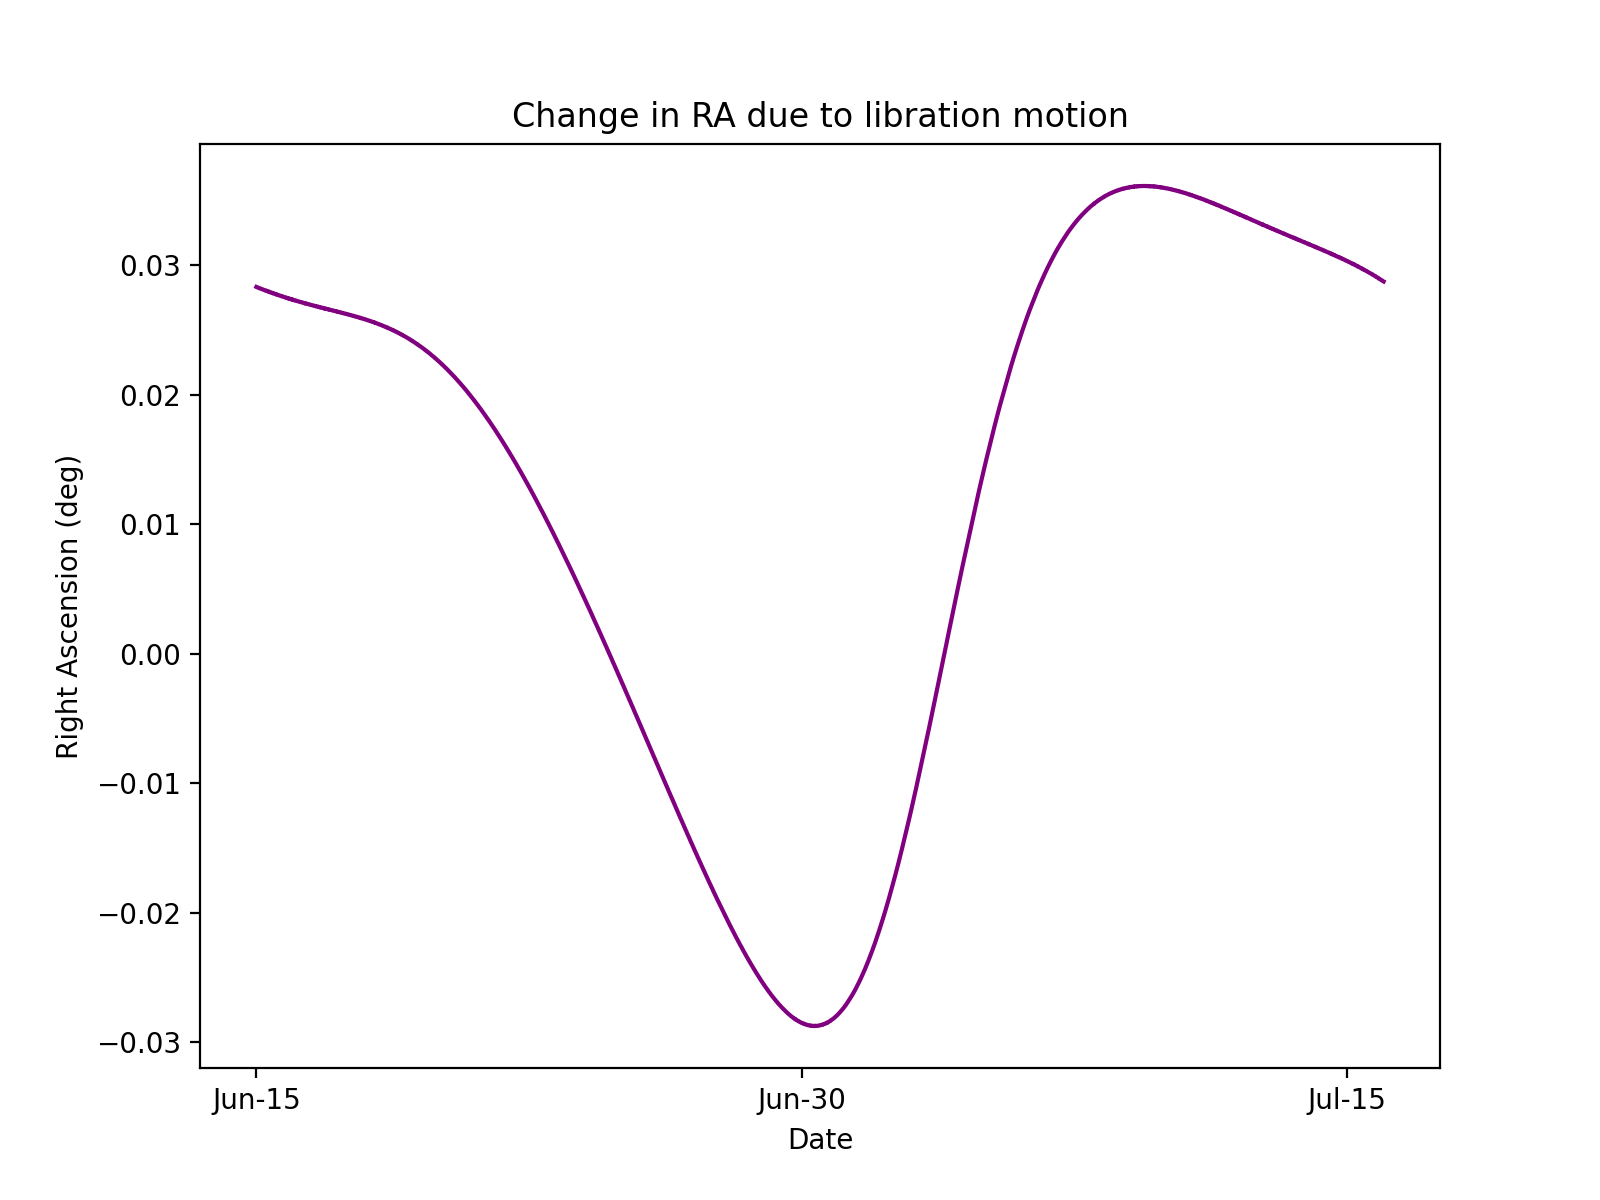

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(times, ras3, color = 'purple')#, label = 'Surveyor-6')
#plt.plot(times, ras2, color = 'purple', label = 'geocentric')
plt.title('Change in RA due to libration motion')
plt.ylabel('Right Ascension (deg)')
plt.xlabel('Date')
plt.xticks([times[0], times[2160], times[4320]], [times[0][5:11], times[2160][5:11], times[4320][5:11]])
plt.show()

<IPython.core.display.Javascript object>


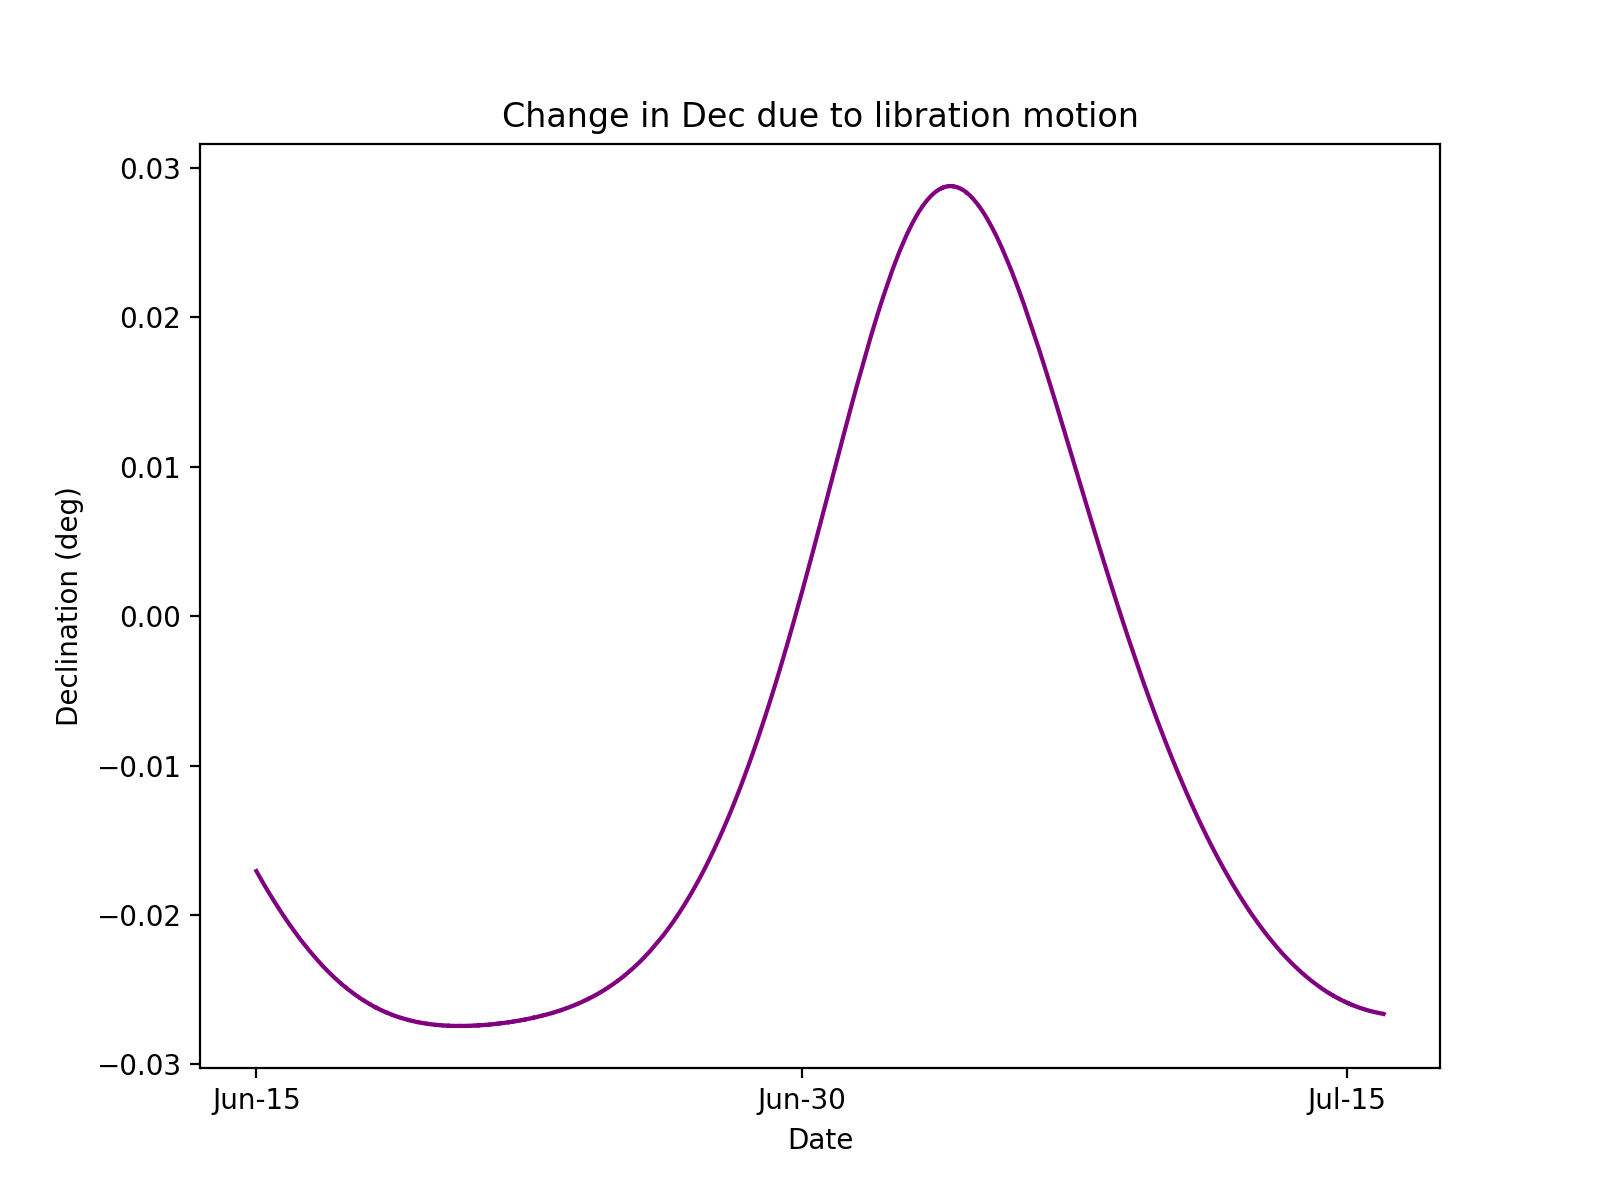

In [18]:
plt.figure(figsize = (8, 6))
plt.plot(times, decs3, color = 'purple')#, label = 'Surveyor-6')
#plt.plot(times, ras2, color = 'purple', label = 'geocentric')
plt.title('Change in Dec due to libration motion')
plt.ylabel('Declination (deg)')
plt.xlabel('Date')
plt.xticks([times[0], times[2160], times[4320]], [times[0][5:11], times[2160][5:11], times[4320][5:11]])
plt.show()

<IPython.core.display.Javascript object>


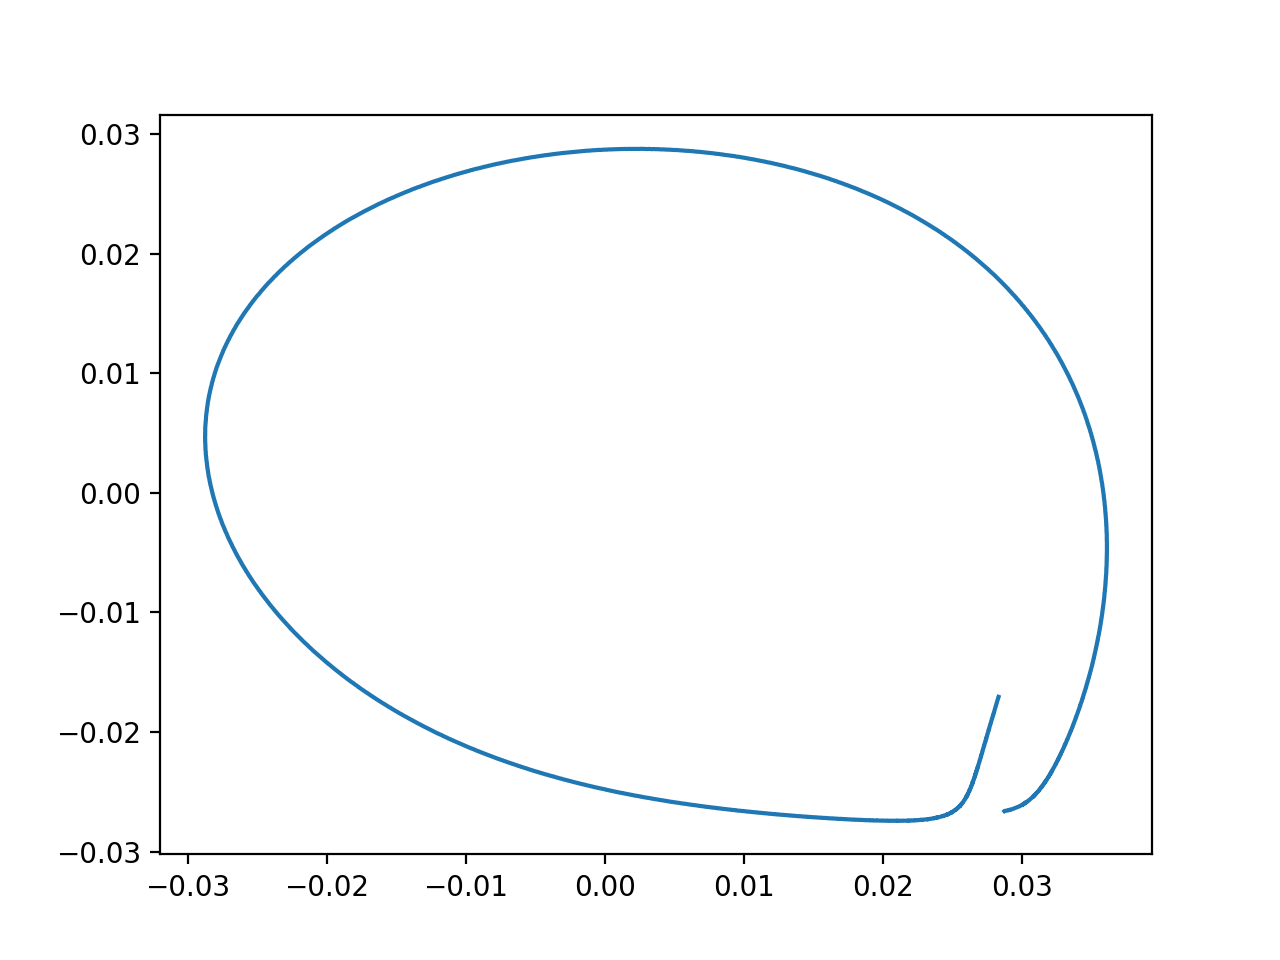

In [19]:
plt.figure()
plt.plot(ras3, decs3)

Looking at how the libration changes with our step size (where it becomes visible/relevant)

In [20]:
#looking at the center of the Eearth from the center of the Moon in time steps of 1 minute
#Change the steps here and below to see the differences. For some reason, this one *has* to 
#be smaller than the one below, I don't know why
mg = Horizons(id = '399', location = '500@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-06-16 00:00', 'step':'1m'})
moon_geo = mg.ephemerides()

In [21]:
#looking at the center of the Eearth from the center of the Moon in time steps of 30 minutes
mg10 = Horizons(id = '399', location = '500@301', epochs = 
                   {'start':'2023-06-15 00:00', 'stop':'2023-06-16 00:00', 'step':'30m'})
moon_geo10 = mg10.ephemerides()

In [22]:
#distance and radial velocities
r_g = []
rdot_g = []
time_g = []
for i in range(len(moon_geo)):
    r_g.append(moon_geo.columns[40][i])
    rdot_g.append(moon_geo.columns[41][i])
    time_g.append(moon_geo.columns[1][i])

r_g10 = []
rdot_g10 = []
time_g10 = []
for i in range(len(moon_geo10)):
    r_g10.append(moon_geo10.columns[40][i])
    rdot_g10.append(moon_geo10.columns[41][i])
    time_g10.append(moon_geo10.columns[1][i])

In [23]:
#difference
dr = []
drdot = []
dt = []
for i in range(len(moon_geo10)):
    for j in range(len(moon_geo)):
        if moon_geo10.columns[1][i] == moon_geo.columns[1][j]:
            dr.append(np.abs(r_g[j] - r_g10[i]))
            drdot.append(np.abs(rdot_g[j] - rdot_g10[i]))
            dt.append(time_g[j])

In [24]:
#doppler shifts
dopp_g = []
dopp_g10 = []
for i in range(len(rdot_g)):
    dopp_g.append(doppler(f, rdot_g[i] * 10**3))
for i in range(len(rdot_g10)):
    dopp_g10.append(doppler(f, rdot_g10[i] * 10**3))

<IPython.core.display.Javascript object>


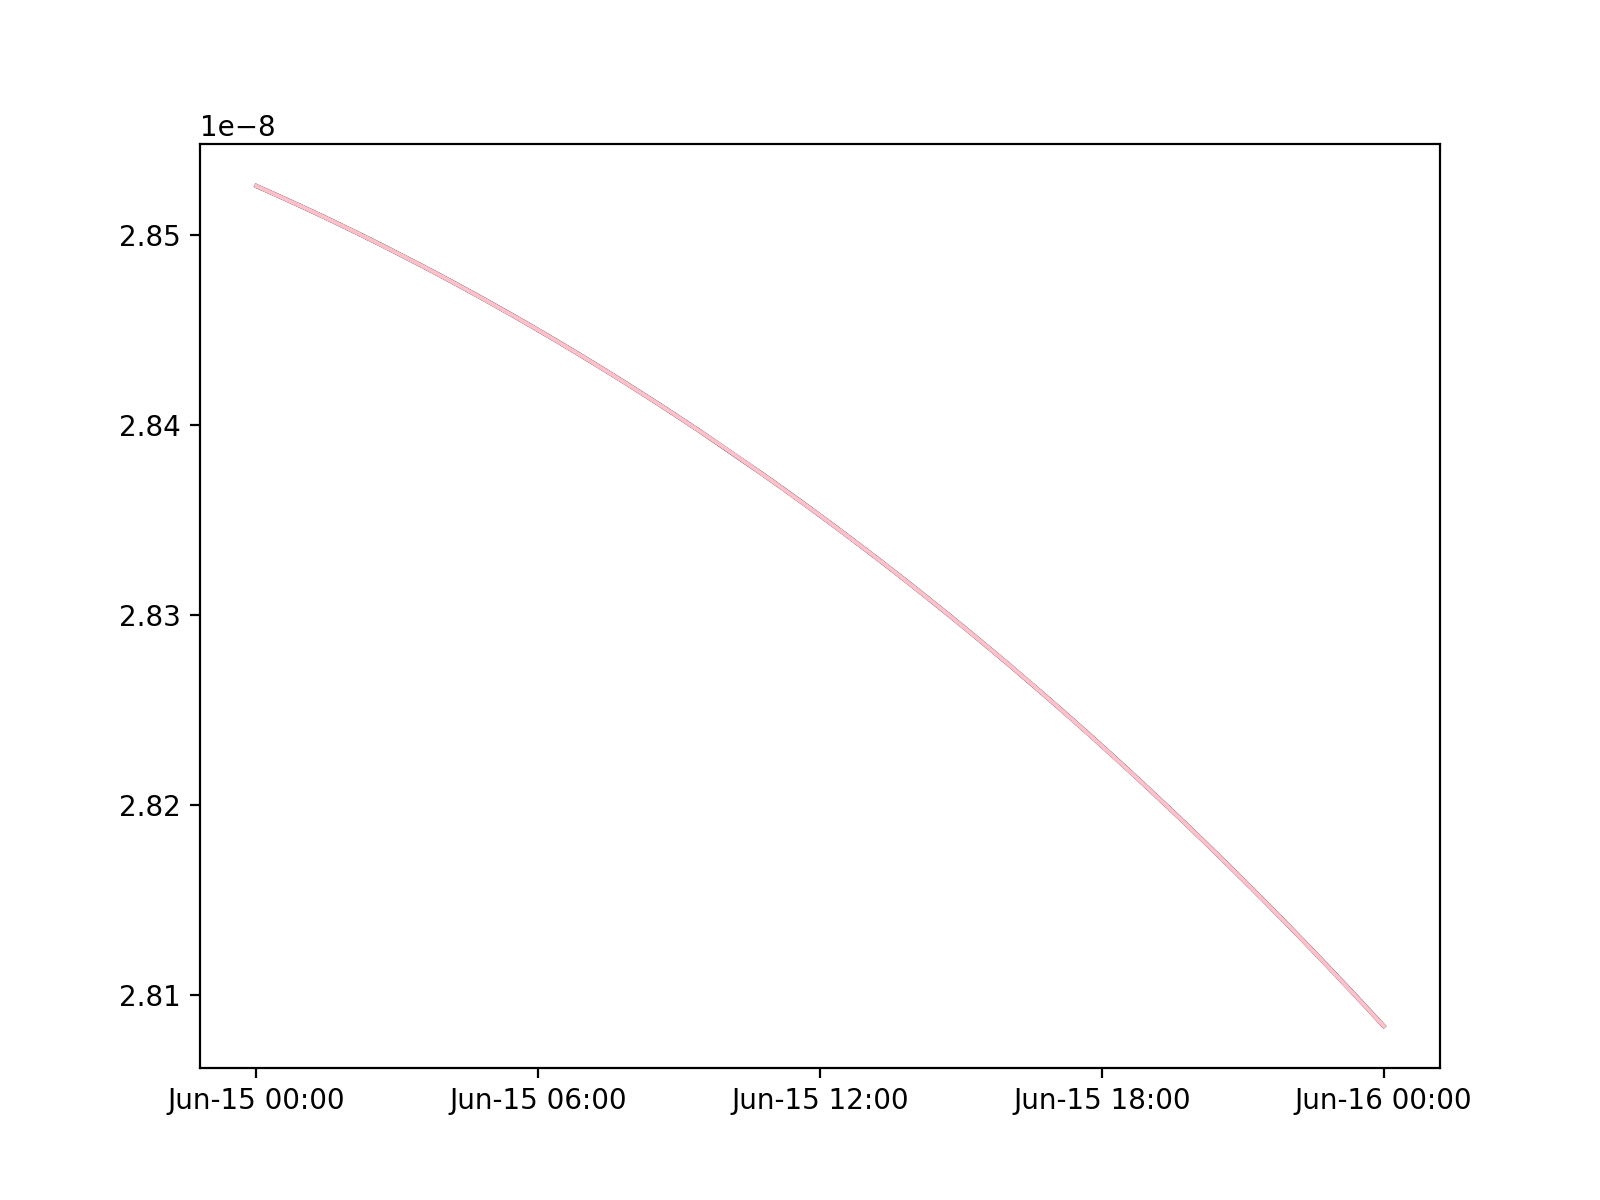

In [25]:
plt.figure(figsize = (8, 6))
plt.plot(time_g, dopp_g, 'k')
plt.plot(time_g10, dopp_g10, 'pink')
plt.xticks([dt[0], dt[12], dt[24], dt[36], dt[48]], 
           [dt[0][5:17], dt[12][5:17], dt[24][5:17], dt[36][5:17], dt[48][5:17]])
plt.show()

<IPython.core.display.Javascript object>


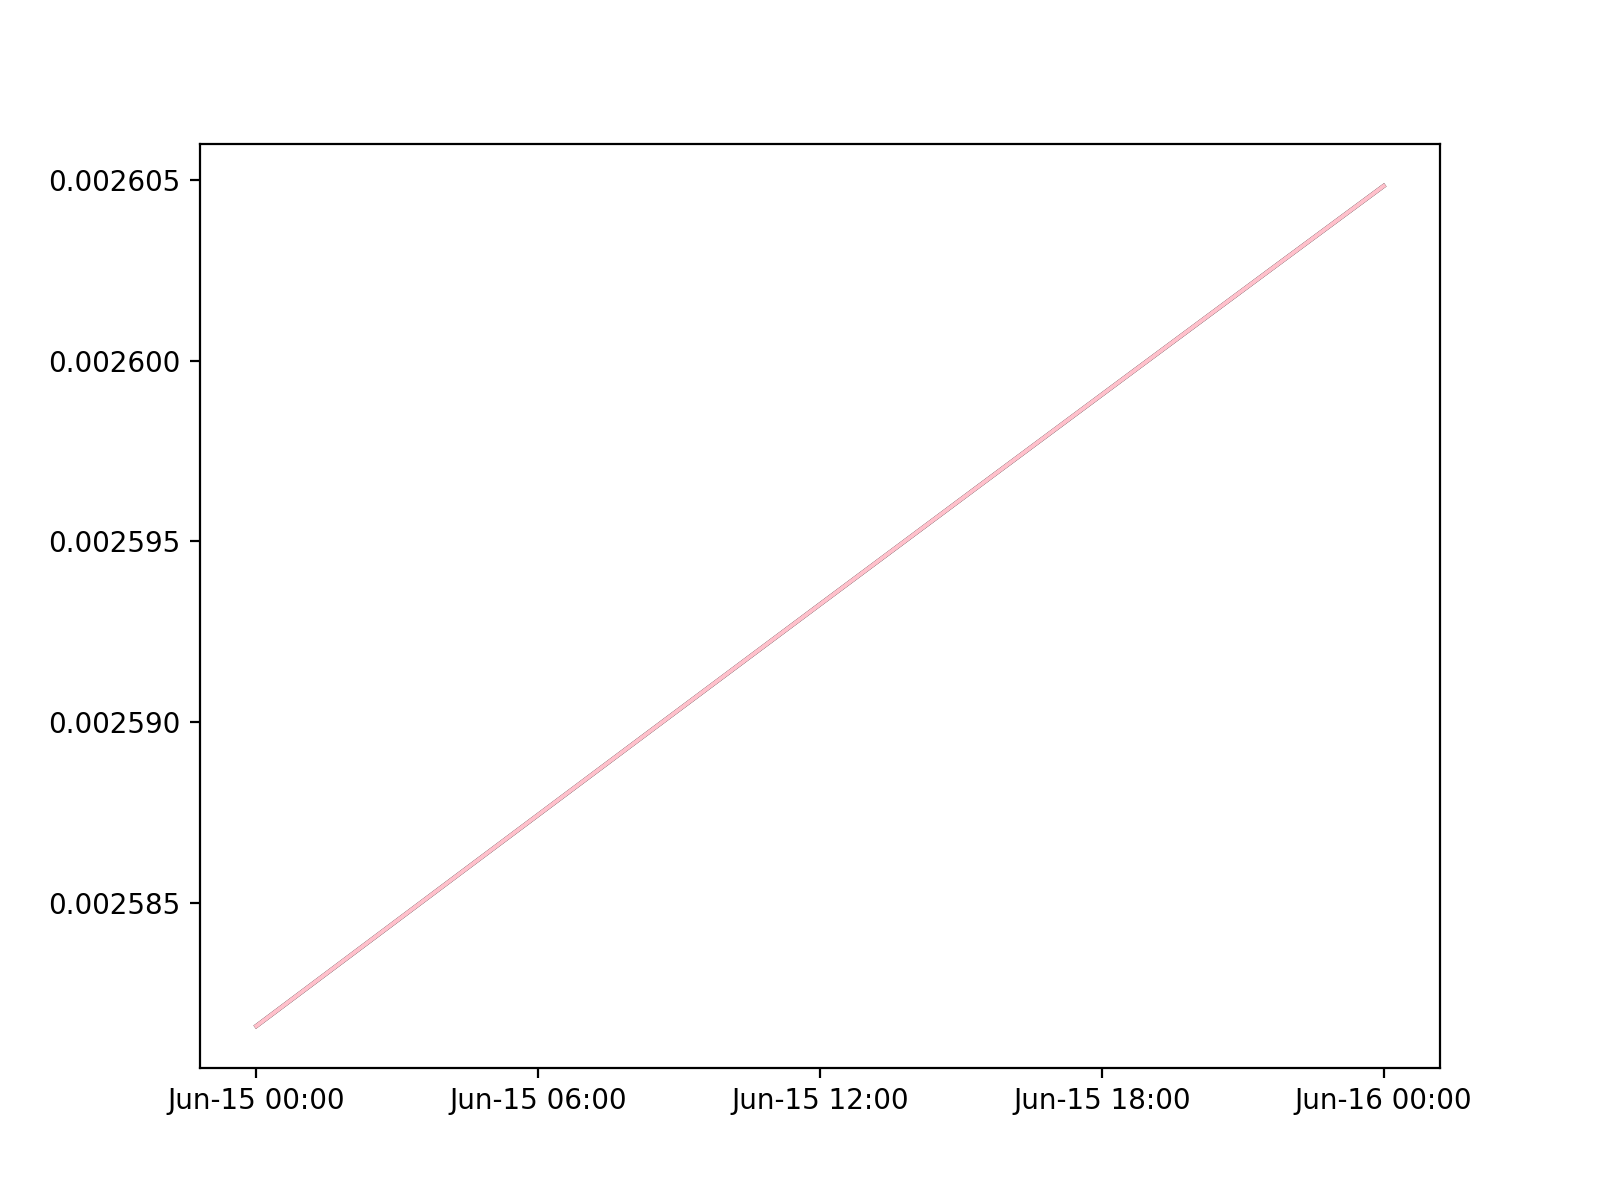

In [26]:
plt.figure(figsize = (8, 6))
plt.plot(time_g, r_g, 'k')
plt.plot(time_g10, r_g10, 'pink')
plt.xticks([dt[0], dt[12], dt[24], dt[36], dt[48]], 
           [dt[0][5:17], dt[12][5:17], dt[24][5:17], dt[36][5:17], dt[48][5:17]])
plt.show()